In [1]:
import flwr as fl 
import pandas as pd
import pickle
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import tasks as ts
import warnings
import argparse
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt




In [2]:
# ts.__dict__

In [2]:
data_1 = pd.read_csv('../IID_df_1.csv')
data_2 = pd.read_csv('../IID_df_2.csv')

In [3]:
scaler = MinMaxScaler()
smote = SMOTE(random_state=422)


In [4]:
test = pd.read_csv('../test_glob.csv')

In [5]:

X_train_2, y_train_2 = data_2.drop(columns=["Fraud"]), data_2["Fraud"]





X_train_scale_2 = scaler.fit_transform(X_train_2)
X_train_2, y_train_2 = smote.fit_resample(X_train_scale_2, y_train_2)


X_test, y_test = test.drop(columns='Fraud'), test.Fraud 
X_test_scale = scaler.transform(X_test)

model = LogisticRegression(
max_iter=10
)

In [6]:


def plot_metrics(losses, ROC_AUC, ACCURACY, F1):
   
    rounds = list(range(1, len(losses) + 1))
    
    plt.figure(figsize=(12, 8))
  
    plt.subplot(2, 2, 1)
    plt.plot(rounds, losses, color='blue')
    plt.title("Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.subplot(2, 2, 2)
    plt.plot(rounds, ROC_AUC, color='green')
    plt.title("ROC AUC over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("ROC AUC")

    plt.subplot(2, 2, 3)
    plt.plot(rounds, ACCURACY, color='orange')
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

    plt.subplot(2, 2, 4)
    plt.plot(rounds, F1, color='red')
    plt.title("F1 Score over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")

    plt.tight_layout()
    plt.show()





In [7]:
X_train, X_test, y_train, y_test = X_train_2, X_test_scale, y_train_2, y_test

In [ ]:
# data = pd.read_csv('../Non_IID_df_1.csv')

In [ ]:
# X_train, y_train = data.drop(columns='Fraud'), data.Fraud

# X_train_scale = scaler.fit_transform(X_train)
# X_train_, y_train_ = smote.fit_resample(X_train_scale, y_train)

In [20]:
class CustomClientDP(fl.client.NumPyClient):
  
    def __init__(self, model, X_train, X_test, y_train, y_test):
        self.model = model
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.losses = []
        self.ROC_AUCs = []
        self.ACCURACYs = []
        self.F1s = []

    def get_parameters(self, config):
         
        return ts.get_model_parameters(model)
    
    def fit(self, parameters, config):
        ts.set_model_parameters(model, parameters)
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model.fit(X_train, y_train)
    
        
        return ts.get_model_parameters(model), len(X_train), {}

    def evaluate(self, parameters, config):
        
        ts.set_model_parameters(model, parameters)
        
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)
        
       
        loss = log_loss(y_test, y_pred_proba)
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        f1 = f1_score(y_test, y_pred)

        print(f'accuracy: {accuracy}')
        print(f'ROC_AUC: {roc_auc}')
        print(f'f1_score: {f1}')

        
        self.losses.append(loss)
        self.ROC_AUCs.append(roc_auc)
        self.ACCURACYs.append(accuracy)
        self.F1s.append(f1)
        
        
        return loss, len(X_test), {"accuracy": accuracy, "roc_auc": roc_auc, "f1-score": f1}


if __name__ == "__main__":
    N_CLIENTS = 2

    model = LogisticRegression(
        max_iter=1,
        warm_start=True
    )

    ts.set_initial_parameters(model)
    
    
    client_dp = CustomClientDP(model, X_train, X_test, y_train, y_test)

    
    fl.client.start_client(
        server_address="127.0.0.1:8080",
        client=client_dp
    )


INFO :      
INFO :      Received: get_parameters message eb91d9ce-5fef-40ef-8eef-b6013943161f
INFO :      Sent reply


INFO :      
INFO :      Received: train message 143e98ca-127f-4406-b8d2-c79afa95b544
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 44fdee42-be20-485e-86e8-429b0d403195
INFO :      Sent reply
INFO :      
INFO :      Received: train message 86c969fc-68ab-4055-9bdf-8a4ebf3b2e4f
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message cbeacb6b-a943-4afa-b2ec-2c5f3802dfde
INFO :      Sent reply
INFO :      
INFO :      Received: train message 770726a9-6ea5-42f0-99cd-8821e29a4831
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 7b97208c-6ff3-4abd-be43-1e451da1cb5f
INFO :      Sent reply
INFO :      
INFO :      Received: train message e3df66dd-6594-4112-a1d1-0ad3d66ef34c
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message e2cd2ae7-62e9-4cd0-8edf-237378aba90f


accuracy: 0.9393644617380026
ROC_AUC: 0.7620293847566574
f1_score: 0.050761421319796954
accuracy: 0.6961738002594033
ROC_AUC: 0.7599250076522804
f1_score: 0.2172096908939014
accuracy: 0.5732814526588845
ROC_AUC: 0.7578321089684726
f1_score: 0.1896551724137931


INFO :      Sent reply
INFO :      
INFO :      Received: train message 0264dc6a-21ac-46d2-ab8e-d2b50fa40ac7
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message c767d582-99b5-431c-9e6f-331ce3a885ca
INFO :      Sent reply
INFO :      
INFO :      Received: train message 1f5ebb8a-2c86-4c45-bd41-9a1f24985915
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 9951bdf6-69f4-403f-81ef-19e58dd61791
INFO :      Sent reply
INFO :      
INFO :      Received: train message 4cbf9f5d-d868-432e-a2a8-bdfd7bb890cb
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message a1ededfb-a9ad-44a7-9875-1286fba41600
INFO :      Sent reply
INFO :      
INFO :      Received: train message d24ab741-880d-4541-a026-e27136b23adf


accuracy: 0.6780155642023347
ROC_AUC: 0.760189011325375
f1_score: 0.21127879269261318
accuracy: 0.5625810635538262
ROC_AUC: 0.7577517600244873
f1_score: 0.18685955394816153
accuracy: 0.6588845654993515
ROC_AUC: 0.7603803183348637
f1_score: 0.2054380664652568
accuracy: 0.7383268482490273
ROC_AUC: 0.7651572543617999
f1_score: 0.21726479146459748


INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 449d98e2-4415-4795-bfb5-16294afc60a1
INFO :      Sent reply
INFO :      
INFO :      Received: train message 4758b404-4a84-49e2-b98b-cd55a2c4924b
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message adb2bcf8-f9ef-412d-a8bc-775128e202c9
INFO :      Sent reply
INFO :      
INFO :      Received: train message 847b29e2-78c9-4ad5-a055-75b4f703b860
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message a8d9e7da-5e78-418a-892c-87a2c35d22ab
INFO :      Sent reply
INFO :      
INFO :      Received: train message 7628d727-2dcf-420c-9463-110505f3c6f9
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 58356fa0-47d0-41f9-b3d8-a38d85e98914
INFO :      Sent reply


accuracy: 0.646887159533074
ROC_AUC: 0.7640878481787573
f1_score: 0.2033650329188003
accuracy: 0.6465629053177692
ROC_AUC: 0.7634507958371596
f1_score: 0.2055393586005831
accuracy: 0.6601815823605707
ROC_AUC: 0.7638774104683195
f1_score: 0.2096530920060332
accuracy: 0.6442931258106356
ROC_AUC: 0.7636038414447506
f1_score: 0.20449601160261058


INFO :      
INFO :      Received: train message 0a918898-bcbe-486f-aa91-86de3bad7601
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message d6d8906f-0cd4-485c-9ec5-349d4cadd75f
INFO :      Sent reply
INFO :      
INFO :      Received: train message 61be9867-b42a-4dcf-8f55-ac47bc56983e
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 52a13428-b07f-4ad7-88ef-a2245e1e6805
INFO :      Sent reply
INFO :      
INFO :      Received: train message c2783805-23d0-42e7-91d1-6380088f30c2
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message d31639f2-cef8-498e-a86e-fb87a9303515
INFO :      Sent reply
INFO :      
INFO :      Received: train message 53da1662-c22d-4aec-b12b-d9a4f62cdda5
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 0140591c-c95f-437c-b0cd-10b2643f7337
INFO :      Sent reply
INFO :      


accuracy: 0.6588845654993515
ROC_AUC: 0.7640648913376187
f1_score: 0.20902255639097744
accuracy: 0.6429961089494164
ROC_AUC: 0.7637530609121518
f1_score: 0.20505415162454874
accuracy: 0.6582360570687419
ROC_AUC: 0.7641930670339762
f1_score: 0.2087087087087087
accuracy: 0.6394293125810635
ROC_AUC: 0.7637874961738598
f1_score: 0.2057142857142857


INFO :      Received: train message 2289e96d-e11f-4215-9750-8d2545dd22ed
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 50ee856d-bee1-4165-9c81-9fd185b51cee
INFO :      Sent reply
INFO :      
INFO :      Received: train message 5abc4380-9dfc-41a5-b7e2-d6e322107c9e
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message cf0e2eb7-381c-4ccf-b1c2-d4c3feff7773
INFO :      Sent reply
INFO :      
INFO :      Received: train message 7a5c4f3d-308d-4fec-a32a-c373c9137191
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 87ea7ff7-43c0-4447-9363-1fda398495a1
INFO :      Sent reply
INFO :      
INFO :      Received: train message 047345e3-9fa1-4210-b848-05dbfb9b7731
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message bdea3016-d387-46cb-b908-ed7137230f83
INFO :      Sent reply
INFO :      
INFO :      Received: train message ae47be32-f951-4e12-8618-a094cf5df9b4
INFO :      Sent reply


accuracy: 0.6559662775616083
ROC_AUC: 0.7641873278236914
f1_score: 0.20761762509335324
accuracy: 0.6825551232166018
ROC_AUC: 0.7641892408937864
f1_score: 0.2085691188358933
accuracy: 0.6559662775616083
ROC_AUC: 0.7638410621365167
f1_score: 0.20524344569288389
accuracy: 0.6533722438391699
ROC_AUC: 0.7640495867768595
f1_score: 0.20638455827765403


INFO :      
INFO :      Received: evaluate message 802a6b0e-fc80-4def-9935-4f6838c5a825
INFO :      Sent reply
INFO :      
INFO :      Received: train message f66752c4-a29e-4832-b2a9-f3ba4581cfa8
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 80ac1599-310f-4736-ad60-154007286705
INFO :      Sent reply
INFO :      
INFO :      Received: train message a9ce56dc-b0c1-4c9d-be7a-660391b03a12
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message c69c88cb-3d14-4b82-bb00-66224d1f1aa6
INFO :      Sent reply
INFO :      
INFO :      Received: train message f3befe4a-af9d-4f4e-ab89-54ad7b52cebe
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message e4731ef3-1078-485e-9579-b6200ac80506
INFO :      Sent reply
INFO :      
INFO :      Received: train message 82ad76ac-49d7-4f62-addd-ee9011e90ca9
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message aa979b09-2901-4e78-b4d1-c69ae7c78712
INFO :      Sent reply


accuracy: 0.6423476005188068
ROC_AUC: 0.7645603764921947
f1_score: 0.2059035277177826
accuracy: 0.6536964980544747
ROC_AUC: 0.7647880318334864
f1_score: 0.20771513353115728
accuracy: 0.6536964980544747
ROC_AUC: 0.7648492500765227
f1_score: 0.20771513353115728
accuracy: 0.6511024643320363
ROC_AUC: 0.7648836853382307
f1_score: 0.20648967551622419
accuracy: 0.648508430609598
ROC_AUC: 0.7649257728803184
f1_score: 0.20760233918128654


INFO :      
INFO :      Received: train message 01d04c6b-3668-4b59-aa4c-226e316ed0db
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 962bfaf1-0a5c-43fa-911e-f84957f6b368
INFO :      Sent reply
INFO :      
INFO :      Received: train message 2d1b63bb-2bd8-4c8a-8d0a-c0f340f2ff3e
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message a44a79b9-1737-4be7-ab32-6199b9a76974
INFO :      Sent reply
INFO :      
INFO :      Received: train message 511d67b6-900b-4e78-ac6e-1bcb9fb8855c
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message d5f52834-f53b-4b86-aaa7-b5e944476bdf
INFO :      Sent reply
INFO :      
INFO :      Received: train message 6c63a2ae-611e-48c1-ae1c-9521bd79729b
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 3a3ca228-6159-4d83-99f0-ae6fd9547ac4
INFO :      Sent reply
INFO :      
INFO :      Received: train message 26360523-be30-41a9-9a51-020242f14654
INFO :      Sent reply


accuracy: 0.643644617380026
ROC_AUC: 0.7649181205999389
f1_score: 0.20535068691250905
accuracy: 0.6543450064850843
ROC_AUC: 0.7652203856749311
f1_score: 0.20684523809523808
accuracy: 0.6446173800259404
ROC_AUC: 0.7651591674318946
f1_score: 0.20579710144927535
accuracy: 0.6326199740596627
ROC_AUC: 0.7657388276706458
f1_score: 0.2037947997189037


INFO :      
INFO :      Received: evaluate message fc8b6914-8059-46f8-8ea9-facf3e86317f
INFO :      Sent reply
INFO :      
INFO :      Received: train message feb26f9d-b9af-4210-b0d6-ab85541848db
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 31449664-7d73-4ace-ac6f-1359d1409cb0
INFO :      Sent reply
INFO :      
INFO :      Received: train message 83a95831-8c48-403d-8930-84209849782f
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message e77ee639-ddf7-41b2-adad-ea859f00063e
INFO :      Sent reply
INFO :      
INFO :      Received: train message 0d60ef0a-f4a6-443b-9d4b-c223c04c2306
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 6ea59db5-4b5c-47d4-be8d-27a2b3bfbaf1
INFO :      Sent reply
INFO :      


accuracy: 0.6416990920881972
ROC_AUC: 0.7658861340679523
f1_score: 0.20674802584350324
accuracy: 0.6433203631647212
ROC_AUC: 0.7660410927456381
f1_score: 0.20634920634920634
accuracy: 0.646887159533074
ROC_AUC: 0.7661348331802877
f1_score: 0.20452885317750183
accuracy: 0.6410505836575876
ROC_AUC: 0.7660353535353535
f1_score: 0.2064516129032258


INFO :      Received: train message 37ac3ff0-5e60-4fb5-b87f-e30a5968e191
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 2f4f3e9c-3fb3-4b1f-931f-d7dd43b2abbd
INFO :      Sent reply
INFO :      
INFO :      Received: train message 36d9b186-bb22-440b-bef7-3a3a6ce1a336
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 7270c4f8-5cfc-477b-bd50-d19e2e0ce78c
INFO :      Sent reply
INFO :      
INFO :      Received: train message 470c7037-5866-4947-a24d-4e94fb212858
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message e71a6ca5-8742-4b02-88b4-9213c95a1bc1
INFO :      Sent reply
INFO :      
INFO :      Received: train message 8d91f243-299f-498a-beea-80e22a3014da
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 0094e24e-5fff-49e5-b892-990c250409f3
INFO :      Sent reply
INFO :      
INFO :      Received: train message ddc295ef-14c8-49f9-a66a-30ff0a4c3a3c
INFO :      Sent reply
INFO :      


accuracy: 0.6488326848249028
ROC_AUC: 0.7670167584940313
f1_score: 0.20542920029347028
accuracy: 0.6371595330739299
ROC_AUC: 0.7668177992041629
f1_score: 0.2046908315565032
accuracy: 0.6384565499351491
ROC_AUC: 0.76694980104071
f1_score: 0.2052744119743407
accuracy: 0.6404020752269779
ROC_AUC: 0.7670607591062136
f1_score: 0.20615604867573373


INFO :      Received: evaluate message 07bbdc6a-503c-4190-bc1c-7bb128ea4ce8
INFO :      Sent reply
INFO :      
INFO :      Received: train message fb594715-31e9-426a-bd4f-25ed3c4b3309
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message b081797e-abc3-4370-81c5-adc1ddaacbc3
INFO :      Sent reply
INFO :      
INFO :      Received: train message 4094c860-ff7a-4515-9282-c499c3ef42be
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 62af300e-fc62-407e-968f-6fa7fd1f924a
INFO :      Sent reply
INFO :      
INFO :      Received: train message 8a0a5144-d24e-4278-9e41-c017aa32d2e1
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message cc6e0fa0-f73d-4311-881d-42d1de60176b
INFO :      Sent reply
INFO :      
INFO :      Received: train message f6825ac1-27eb-43dd-9161-132c84996317
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message d1a2cceb-20b7-4c55-aac7-fb1b821f81d1
INFO :      Sent reply
INFO :      
INFO

accuracy: 0.6501297016861219
ROC_AUC: 0.7672520661157025
f1_score: 0.20486366985998525
accuracy: 0.6400778210116731
ROC_AUC: 0.7671487603305784
f1_score: 0.20373027259684362
accuracy: 0.6384565499351491
ROC_AUC: 0.7671391949801041
f1_score: 0.2052744119743407
accuracy: 0.6316472114137484
ROC_AUC: 0.7673974594429139
f1_score: 0.20336605890603085
accuracy: 0.6394293125810635
ROC_AUC: 0.7675868533823079
f1_score: 0.2034383954154728


INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message be9e0d69-ad88-49b6-9fe6-133ad4ecbdbf
INFO :      Sent reply
INFO :      
INFO :      Received: train message e6e795a7-8b7b-447f-8174-99639b97885d
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message d4879b96-907e-4423-b0a3-1bee65296346
INFO :      Sent reply
INFO :      
INFO :      Received: train message eb834709-6c13-444c-9d4e-25bd619f7957
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message f65884cf-185c-4aa4-a5f1-246908b48d94
INFO :      Sent reply
INFO :      
INFO :      Received: train message 23169158-0253-4ddd-bae4-7c5abb7eb228
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 8d4ca1dc-8d69-40bb-94e7-8615ddd1ef98
INFO :      Sent reply
INFO :      
INFO :      Received: train message 687c29d8-cd18-4e33-ad41-f7f6d2720751
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message c8e6d4a1-93d5-4d5c-9faa-c6a672421bd9
INFO

accuracy: 0.6416990920881972
ROC_AUC: 0.7676595500459137
f1_score: 0.20331651045421772
accuracy: 0.6345654993514915
ROC_AUC: 0.767516069788797
f1_score: 0.20353356890459365
accuracy: 0.6404020752269779
ROC_AUC: 0.7675734618916437
f1_score: 0.20273184759166069
accuracy: 0.642023346303502
ROC_AUC: 0.7675983318028774
f1_score: 0.20346320346320346
accuracy: 0.6605058365758755
ROC_AUC: 0.7663720538720539
f1_score: 0.20621683093252463


INFO :      
INFO :      Received: evaluate message 9b13c81e-122c-4c4c-8c5a-522336955d70
INFO :      Sent reply
INFO :      
INFO :      Received: train message fdad7ad9-ba6e-4194-8843-26f425325f86
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message d16adfc2-dd6b-4cf3-8461-5d6c3e976855
INFO :      Sent reply
INFO :      
INFO :      Received: train message ab64aa81-dec5-48ca-9916-cb188c30b359
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 278b26a1-aa51-43db-a370-347ee7ea30de
INFO :      Sent reply
INFO :      
INFO :      Received: train message 702bca5e-b25e-4266-9a47-5a5d47e8b08d
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message c7775d74-b61c-4d76-b8fa-16e726fa574a
INFO :      Sent reply
INFO :      
INFO :      Received: reconnect message 18db0578-4f4c-492e-a3c0-6e6f8e44d9f9
INFO :      Disconnect and shut down


accuracy: 0.6498054474708171
ROC_AUC: 0.7663624885215794
f1_score: 0.20353982300884957
accuracy: 0.6449416342412452
ROC_AUC: 0.7664409243954697
f1_score: 0.202476329206118
accuracy: 0.6579118028534371
ROC_AUC: 0.7668082338536885
f1_score: 0.20736288504883546
accuracy: 0.6465629053177692
ROC_AUC: 0.7666972757881849
f1_score: 0.20321637426900585


---

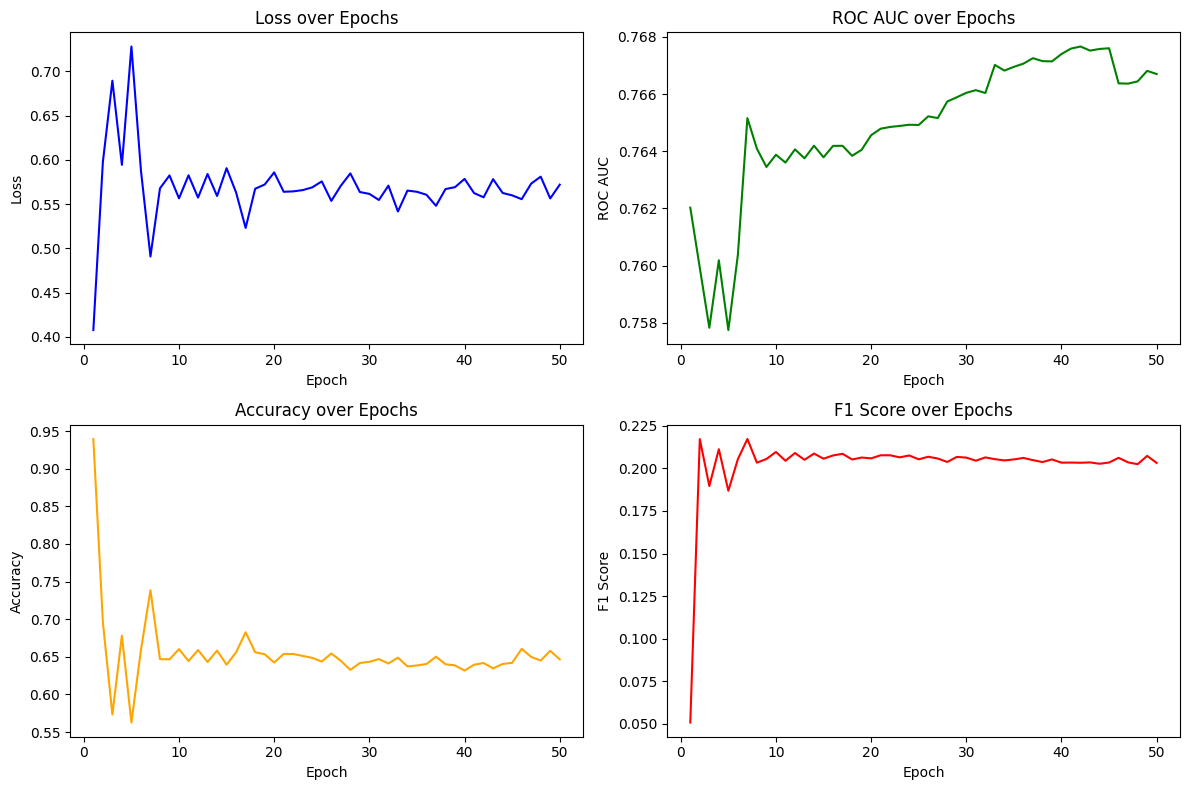

In [30]:
L, ROC_AUC, ACCURACY, F1 = client_dp.losses, client_dp.ROC_AUCs, client_dp.ACCURACYs, client_dp.F1s

plot_metrics(L, ROC_AUC, ACCURACY, F1)

In [14]:
L_dp_fixed, ROC_AUC_dp_fixed, ACCURACY_dp_fixed, F1_dp_fixed = L, ROC_AUC, ACCURACY, F1 

In [19]:
L_dp_adap, ROC_AUC_dp_adap, ACCURACY_dp_adap, F1_dp_adap = L, ROC_AUC, ACCURACY, F1 

In [31]:
L_fedavg, ROC_AUC_fedavg, ACCURACY_fedavg, F1_fedavg = L, ROC_AUC, ACCURACY, F1



In [33]:
L_dp_adap == L_dp_fixed

False

In [ ]:
def plot_metrics_comparison_simple(L_1, ROC_AUC_1, ACCURACY_1, F1_1, 
                                   L_2, ROC_AUC_2, ACCURACY_2, F1_2,
                                   L_3, ROC_AUC_3, ACCURACY_3, F1_3):
    rounds = list(range(1, len(L_1) + 1))
    
    plt.figure(figsize=(12, 8))
  
    # Loss Comparison
    plt.subplot(2, 2, 1)
    plt.plot(rounds, L_1, color='blue', label='FedAvg')
    plt.plot(rounds, L_2, color='orange', label='DP_fixed')
    plt.plot(rounds, L_3, color='green', label='DP_Adaptive')
    plt.title("Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # ROC AUC Comparison
    plt.subplot(2, 2, 2)
    plt.plot(rounds, ROC_AUC_1, color='blue', label='FedAvg')
    plt.plot(rounds, ROC_AUC_2, color='orange', label='DP_fixed')
    plt.plot(rounds, ROC_AUC_3, color='green', label='DP_Adaptive')
    plt.title("ROC AUC over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("ROC AUC")
    plt.legend()

    # Accuracy Comparison
    plt.subplot(2, 2, 3)
    plt.plot(rounds, ACCURACY_1, color='blue', label='FedAvg')
    plt.plot(rounds, ACCURACY_2, color='orange', label='DP_fixed')
    plt.plot(rounds, ACCURACY_3, color='green', label='DP_Adaptive')
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # F1 Score Comparison
    plt.subplot(2, 2, 4)
    plt.plot(rounds, F1_1, color='blue', label='FedAvg')
    plt.plot(rounds, F1_2, color='orange', label='DP_fixed')
    plt.plot(rounds, F1_3, color='green', label='DP_Adaptive')
    plt.title("F1 Score over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Пример вызова функции с тремя наборами данных для каждой метрики
plot_metrics_comparison_simple(L_fedavg, ROC_AUC_fedavg, ACCURACY_fedavg, F1_fedavg, 
                               L_dp_fixed, ROC_AUC_dp_fixed, ACCURACY_dp_fixed, F1_dp_fixed,
                               L_dp_adap, ROC_AUC_dp_adap, ACCURACY_dp_adap, F1_dp_adap)

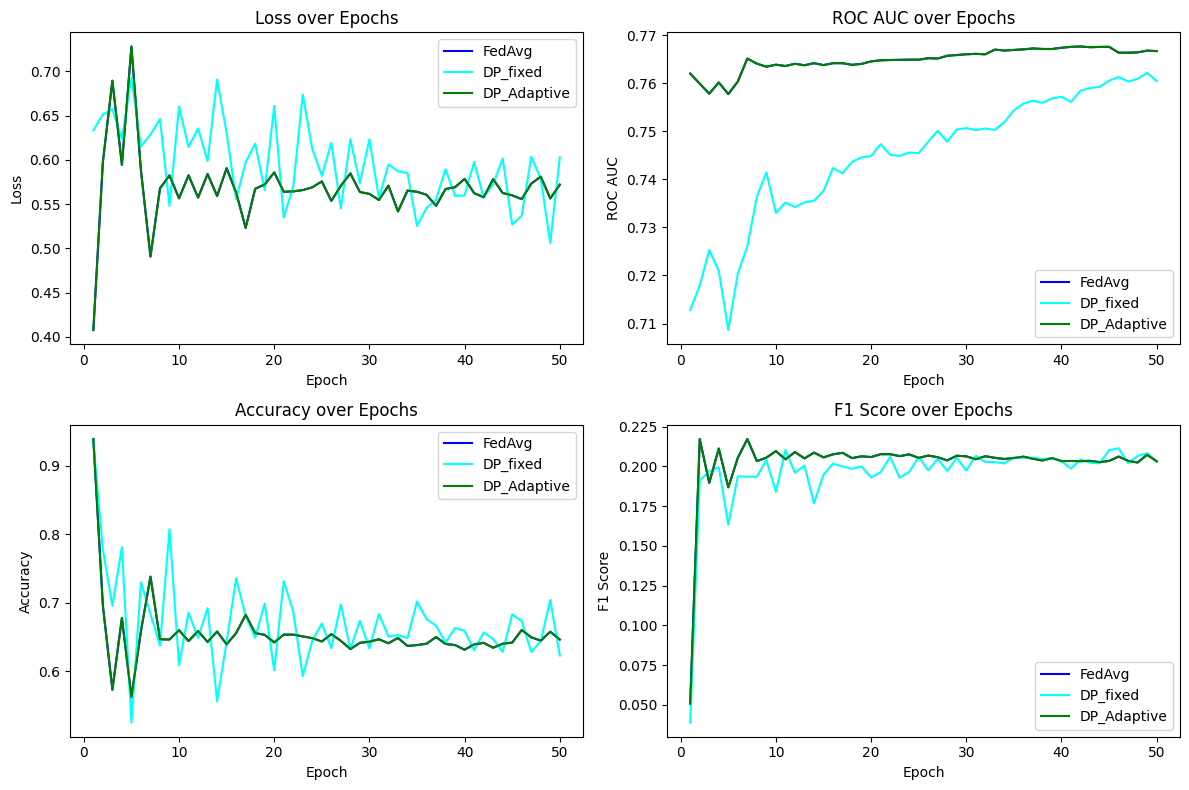

In [11]:
class CustomClient_Paillier(fl.client.NumPyClient):

        
    def __init__(self, model, X_train, X_test, y_train, y_test):
        self.model = model
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.losses = []
        self.ROC_AUCs = []
        self.ACCURACYs = []
        self.F1s = []
    
        with open('../public_key.pkl', 'rb') as f:
            self.__public_key = pickle.load(f)

        with open('../private_key.pkl', 'rb') as f:
            self.__private_key = pickle.load(f)


    def get_parameters(self, config):

        print('================== INITIAL PARAMS ==================')
        params = ts.get_model_parameters(model)
        print(params)

        return params

    def fit(self, parameters, config):
        
        print('============================ PARAMS BEFORE  FIT===========================')
  
        # decrypted_params = [(self.__private_key.decrypt(value),) for param in parameters for value in param.flatten()]
        # dec_res = []
        # index = 0
        # for param in parameters:
        #        num_elements = param.size
        #        reshaped_array = np.array(decrypted_params[index:index + num_elements]).reshape(param.shape)
        #        dec_res.append(reshaped_array)
        #        index += num_elements
        # print(parameters)
        
        ts.set_model_parameters(model, parameters)
                
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model.fit(X_train, y_train)
        print(f"Training finished for round {config['server_round']}")
        print('============================= PARAMETERS AFTER FIT ===============================')
        params_1 = ts.get_model_parameters(model)
        print(f'clear: {params_1}')

        encrypted_params = [(self.__public_key.encrypt(value),) for param in params_1 for value in param.flatten()]
        enc_result = []
        index = 0

        for param in params_1:
                num_elements = param.size
                reshaped_array = np.array(encrypted_params[index:index + num_elements]).reshape(param.shape)
                enc_result.append(reshaped_array)
                index += num_elements
            # encrypt parameters here


        print(f'Encrypted: {enc_result}')
        
        return enc_result, len(X_train), {}

    def evaluate(self, parameters, config):
        print('========================== evaluate PARAMS =============================================')
        # i got agg parameters for server, here i have to decrypt them
        print(parameters, parameters[0].size, parameters[1].size)
        decrypted_params = [(self.__private_key.decrypt(value),) for param in parameters for value in param.flatten()]
        dec_res = []
        index = 0
        for param in parameters:
               num_elements = param.size
               reshaped_array = np.array(decrypted_params[index:index + num_elements]).reshape(param.shape)
               dec_res.append(reshaped_array)
               index += num_elements
        print(f' Decrypted for EVAL {dec_res}')


        
        ts.set_model_parameters(model, dec_res)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)
        loss = log_loss(y_test, y_pred_proba)
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        f1 = f1_score(y_test, y_pred)
        print(f'accuracy: {accuracy}')
        print(f'ROC_AUC: {roc_auc}')
        print(f'f1_score: {f1}')
        self.losses.append(loss)
        self.ROC_AUCs.append(roc_auc)
        self.ACCURACYs.append(accuracy)
        self.F1s.append(f1)
        
        
        parameters[0] = dec_res[0]
        parameters[1]  = dec_res[1]
        print('parameters after eval MUST BE DECRYPTED!')
        print(parameters)
        
        return loss, len(X_test), {"accuracy": accuracy, "roc_auc": roc_auc, "f1-score": f1}

if __name__ == "__main__":


    client_paillier = CustomClient_Paillier(model, X_train, X_test, y_train, y_test)
    model = LogisticRegression(
        max_iter=1,
    
    )

    ts.set_initial_parameters(model)

    fl.client.start_client(
        server_address="127.0.0.1:8080",
        client=client_paillier
    )

INFO :      
INFO :      Received: get_parameters message 9c7f62d0-cd2d-44ae-8301-fbd428351a45
INFO :      Sent reply


================== INITIAL PARAMS ==================
[array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]]), array([0.])]


INFO :      
INFO :      Received: train message a24f16ae-f71b-454f-9faa-f6f87e182c43


============================ PARAMS BEFORE  FIT===========================
Training finished for round 1
============================= PARAMETERS AFTER FIT ===============================
clear: [array([[-4.39520118e-02, -4.94452864e-02, -6.87200648e-02,
        -8.81334124e-02, -7.64466791e-02,  5.43694916e-02,
        -8.19209966e-02, -3.00138760e-03,  2.10840073e-01,
        -1.80182279e-02, -8.22151147e-02, -5.74585683e-01,
        -6.71071985e-02, -2.65962553e-01,  9.13177174e-02,
        -6.60401510e-02,  4.96981409e-02, -1.14521284e-02,
         4.78860164e-02,  2.81303462e-03, -5.54664466e-04,
        -2.65126517e-01, -8.98509592e-02, -3.21844743e-02,
        -3.04851714e-03, -3.01344921e-02, -2.05836861e-01,
        -1.18783449e-02, -3.35765342e-03, -1.05524195e-01,
        -5.98688082e-01,  0.00000000e+00,  2.61255263e-02]]), array([2.52263739e-16])]


INFO :      Sent reply


Encrypted: [array([[<phe.paillier.EncryptedNumber object at 0x000002AFA38F16C0>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000002AFA38F2D70>],
      dtype=object)]


INFO :      
INFO :      Received: evaluate message 922789e4-1537-46a6-9b37-6f7811a963f3


========================== evaluate PARAMS =============================================
[array([[<phe.paillier.EncryptedNumber object at 0x000002AFA38F3790>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000002AFA38F22F0>],
      dtype=object)] 33 1


INFO :      Sent reply
INFO :      
INFO :      Received: train message 4998d015-2a3b-4edd-b4f7-3018a60ecde8


 Decrypted for EVAL [array([[-0.04035642, -0.06838285, -0.04901064, -0.08041477, -0.05967494,
         0.0137327 , -0.05450042, -0.0270502 ,  0.1934429 , -0.01912221,
        -0.06654014, -0.60300138, -0.08105414, -0.28374685,  0.08911177,
        -0.06062822, -0.00356938,  0.00323606,  0.0363628 , -0.00799729,
        -0.00237556, -0.21984822, -0.07152266, -0.0411051 , -0.00924902,
        -0.03192408, -0.15789523, -0.01266152, -0.00180927, -0.0951876 ,
        -0.60414156,  0.        ,  0.0384818 ]]), array([2.60270951e-16])]
accuracy: 0.9393644617380026
ROC_AUC: 0.7620293847566574
f1_score: 0.050761421319796954
parameters after eval MUST BE DECRYPTED!
[array([[-0.04035642, -0.06838285, -0.04901064, -0.08041477, -0.05967494,
         0.0137327 , -0.05450042, -0.0270502 ,  0.1934429 , -0.01912221,
        -0.06654014, -0.60300138, -0.08105414, -0.28374685,  0.08911177,
        -0.06062822, -0.00356938,  0.00323606,  0.0363628 , -0.00799729,
        -0.00237556, -0.21984822, -0.0715226

INFO :      Sent reply


Encrypted: [array([[<phe.paillier.EncryptedNumber object at 0x000002AFA38F3A90>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000002AFA38F24D0>],
      dtype=object)]


_MultiThreadedRendezvous: <_MultiThreadedRendezvous of RPC that terminated with:
	status = StatusCode.UNAVAILABLE
	details = "Connection reset"
	debug_error_string = "UNKNOWN:Error received from peer ipv4:127.0.0.1:8080 {created_time:"2024-11-06T18:53:30.8803014+00:00", grpc_status:14, grpc_message:"Connection reset"}"
>

In [ ]:
L_paiil, ROC_AUC_paill, ACCURACY_paill, F1_paill = client_paillier.losses, client_paillier.ROC_AUCs, client_paillier.ACCURACYs, client_paillier.F1s
plot_metrics(L, ROC_AUC, ACCURACY, F1)

In [11]:
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Context

In [7]:
class CustomClient(fl.client.NumPyClient):
    
    def __init__(self):
        
        super().__init__()
        self.lOSS = []
        self.ROC_AUC = []
        self.ACCURACY = []
        self.F1 = []



    def fit(self, parameters, config):
        ts.set_model_parameters(model, parameters)
        print(f'STUDY ::: [LOCAL FIT]')
       
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model.fit(X_train_2, y_train_2)
        
        return ts.get_model_parameters(model), len(X_train_2), {}

    def evaluate(self, parameters, config):
        print(f'STUDY ::: [EVALUATE]')
        ts.set_model_parameters(model, parameters)
        
        y_pred_proba = model.predict_proba(X_test_scale)[:, 1]
        y_pred = model.predict(X_test_scale)
        
        loss = log_loss(y_test, y_pred_proba)
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        f1 = f1_score(y_test, y_pred)

        print(f'Accuracy: {accuracy}')
        print(f'ROC_AUC: {roc_auc}')
        print(f'F1_score: {f1}')

        self.lOSS.append(loss)
        self.ROC_AUC.append(roc_auc)
        self.ACCURACY.append(accuracy)
        self.F1.append(f1)
        
        
        return loss, len(X_test_scale), {"accuracy": accuracy, "roc_auc": roc_auc, "f1-score": f1}


if __name__ == "__main__":
    
    N_CLIENTS = 2

    model = LogisticRegression(
        penalty='l2',
        max_iter=10
    )

    ts.set_initial_parameters(model)
    
    
    client = CustomClient()

    
    fl.client.start_client(
        server_address="127.0.0.1:8080",
        client=client
    )

INFO :      
INFO :      Received: get_parameters message 7c478650-82d1-48f5-8582-4221df9f2494
INFO :      Sent reply


INFO :      
INFO :      Received: train message 5d88dc24-eba1-4cf8-ac99-594545e06725
ERROR :     Client raised an exception.
Traceback (most recent call last):
  File "c:\Users\Астемир\.pyenv\pyenv-win\versions\3.10.6\lib\site-packages\flwr\client\app.py", line 379, in _start_client_internal
    reply_message = client_app(message=message, context=context)
  File "c:\Users\Астемир\.pyenv\pyenv-win\versions\3.10.6\lib\site-packages\flwr\client\client_app.py", line 98, in __call__
    return self._call(message, context)
  File "c:\Users\Астемир\.pyenv\pyenv-win\versions\3.10.6\lib\site-packages\flwr\client\client_app.py", line 81, in ffn
    out_message = handle_legacy_message_from_msgtype(
  File "c:\Users\Астемир\.pyenv\pyenv-win\versions\3.10.6\lib\site-packages\flwr\client\message_handler\message_handler.py", line 130, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
  File "c:\Users\Астемир\.pyenv\pyenv-win\versions\3.10.6\lib\site-packages\flwr\client\client.py",

IndexError: list index out of range